In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import models, transforms
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [8]:
DATA_DIR = "../content/processed_data"
BATCH_SIZE = 32
EPOCHS = 10  # Epochs per fold
K_FOLDS = 5  # As requested in the document 
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CLASSES = ["Hemorrhagic", "Ischemic", "Tumor"]

In [9]:
# Define Standard Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [10]:
class NeuroDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []
        self.class_map = {name: i for i, name in enumerate(CLASSES)}
        
        # Load all images
        for cls_name in CLASSES:
            cls_folder = os.path.join(root_dir, cls_name)
            if not os.path.exists(cls_folder): continue
            
            fnames = [f for f in os.listdir(cls_folder) if f.endswith(('.jpg', '.png'))]
            for f in fnames:
                self.samples.append((os.path.join(cls_folder, f), self.class_map[cls_name]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [11]:
# Initialize Dataset
full_dataset = NeuroDataset(DATA_DIR, transform=transform)
print(f"Dataset Loaded: {len(full_dataset)} total images.")

Dataset Loaded: 6216 total images.


In [12]:
def get_model():
    # Load Pre-trained ResNet50 
    model = models.resnet50(pretrained=True)
    
    # Modify the final fully connected layer
    # ResNet50's last layer is named 'fc' and has 2048 input features
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, len(CLASSES))
    
    return model.to(DEVICE)

# Quick check
model_test = get_model()
print("Model Architecture Ready: ResNet50 modified for 3 classes.")

d:\Gam3a\Senior2\Neuroengineer\project\Stroke-Tumor-Classification\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Gam3a\Senior2\Neuroengineer\project\Stroke-Tumor-Classification\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model Architecture Ready: ResNet50 modified for 3 classes.


In [16]:
from sklearn.model_selection import GroupKFold

def train_kfold_safe(dataset, k=5, epochs=10):
    # 1. Extract Groups (Patient IDs)
    # Filenames are like: "real_123.jpg" or "aug_123_0.jpg"
    patient_ids = []
    for path, label in dataset.samples:
        filename = os.path.basename(path)
        # Split by '_' and grab the 2nd element (the ID)
        pid = filename.split('_')[1] 
        patient_ids.append(pid)
        
    patient_ids = np.array(patient_ids)
    
    # 2. Use GroupKFold instead of KFold
    gkf = GroupKFold(n_splits=k)
    
    history = {'fold_acc': []}
    print(f"Starting {k}-Fold Cross-Validation (Leak-Proof)...")
    print("-" * 50)
    
    best_acc = 0.0
    
    # Split based on Groups
    # We pass 'patient_ids' as the groups argument
    # X and y can be dummy arrays here since we access dataset by index
    dummy_X = np.zeros(len(dataset)) 
    dummy_y = np.zeros(len(dataset))
    
    for fold, (train_idx, val_idx) in enumerate(gkf.split(dummy_X, dummy_y, groups=patient_ids)):
        print(f"\nFOLD {fold+1}/{k}")
        
        # Setup Samplers
        train_sub = SubsetRandomSampler(train_idx)
        val_sub = SubsetRandomSampler(val_idx)
        
        train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sub)
        val_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=val_sub)
        
        # Reset Model
        model = get_model()
        optimizer = optim.Adam(model.parameters(), lr=0.0001)
        criterion = nn.CrossEntropyLoss()
        
        # Train
        for epoch in range(epochs):
            model.train()
            train_loss = 0.0
            for images, labels in tqdm(train_loader, desc=f"Ep {epoch+1}", leave=False):
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                optimizer.zero_grad()
                loss = criterion(model(images), labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                
        # Validate
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        acc = 100 * correct / total
        print(f"Fold {fold+1} Accuracy: {acc:.2f}%")
        history['fold_acc'].append(acc)
        
        if acc > best_acc:
            best_acc = acc
            torch.save(model.state_dict(), "best_resnet_model_safe.pth")
            print("--> Saved Best Model")

    print("\n" + "="*30)
    print(f"True Average Accuracy: {np.mean(history['fold_acc']):.2f}%")
    print("="*30)

# Run the Safe Training
train_kfold_safe(full_dataset, k=K_FOLDS, epochs=EPOCHS)

Starting 5-Fold Cross-Validation (Leak-Proof)...
--------------------------------------------------

FOLD 1/5


d:\Gam3a\Senior2\Neuroengineer\project\Stroke-Tumor-Classification\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Gam3a\Senior2\Neuroengineer\project\Stroke-Tumor-Classification\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold 1 Accuracy: 99.92%
--> Saved Best Model

FOLD 2/5


Fold 2 Accuracy: 100.00%
--> Saved Best Model

FOLD 3/5


KeyboardInterrupt: 

In [20]:
from sklearn.model_selection import GroupKFold

def train_kfold_safe_noisy(dataset, k=5, epochs=10, noise_level=0.05):
    """
    noise_level: Intensity of the noise (0.05 = 5% variance). 
                 Higher = Harder for the model.
    """
    # 1. Extract Groups
    patient_ids = []
    for path, label in dataset.samples:
        filename = os.path.basename(path)
        pid = filename.split('_')[1] 
        patient_ids.append(pid)
    patient_ids = np.array(patient_ids)
    
    # 2. GroupKFold
    gkf = GroupKFold(n_splits=k)
    history = {'fold_acc': []}
    
    print(f"Starting {k}-Fold CV with Gaussian Noise Injection (Level: {noise_level})...")
    print("-" * 50)
    
    best_acc = 0.0
    
    dummy_X = np.zeros(len(dataset)) 
    dummy_y = np.zeros(len(dataset))
    
    for fold, (train_idx, val_idx) in enumerate(gkf.split(dummy_X, dummy_y, groups=patient_ids)):
        print(f"\nFOLD {fold+1}/{k}")
        
        # Samplers
        train_sub = SubsetRandomSampler(train_idx)
        val_sub = SubsetRandomSampler(val_idx)
        
        train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sub)
        val_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=val_sub)
        
        # Reset Model
        model = get_model()
        optimizer = optim.Adam(model.parameters(), lr=0.0001)
        criterion = nn.CrossEntropyLoss()
        
        # --- TRAINING PHASE ---
        for epoch in range(epochs):
            model.train()
            train_loss = 0.0
            
            for images, labels in tqdm(train_loader, desc=f"Ep {epoch+1}", leave=False):
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                
                # --- NEW: ADD NOISE HERE ---
                # We create a random noise tensor of the same shape as the images
                # and add it. This changes every single batch!
                noise = torch.randn_like(images) * noise_level
                noisy_images = images + noise
                # ---------------------------
                
                optimizer.zero_grad()
                
                # Train on NOISY images
                loss = criterion(model(noisy_images), labels)
                
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                
        # --- VALIDATION PHASE ---
        # Note: We do NOT add noise to validation. We want to test on clean images.
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        acc = 100 * correct / total
        print(f"Fold {fold+1} Accuracy: {acc:.2f}%")
        history['fold_acc'].append(acc)
        
        if acc > best_acc:
            best_acc = acc
            torch.save(model.state_dict(), "best_resnet_model_safe_noisy_data.pth")
            print("--> Saved Best Model")

    print("\n" + "="*30)
    print(f"True Average Accuracy: {np.mean(history['fold_acc']):.2f}%")
    print("="*30)

# Run with noise
train_kfold_safe_noisy(full_dataset, k=5, epochs=10, noise_level=0.1)

Starting 5-Fold CV with Gaussian Noise Injection (Level: 0.1)...
--------------------------------------------------

FOLD 1/5


d:\Gam3a\Senior2\Neuroengineer\project\Stroke-Tumor-Classification\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Gam3a\Senior2\Neuroengineer\project\Stroke-Tumor-Classification\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold 1 Accuracy: 91.40%
--> Saved Best Model

FOLD 2/5


Fold 2 Accuracy: 95.58%
--> Saved Best Model

FOLD 3/5


KeyboardInterrupt: 

Generating Evaluation Metrics...


100%|██████████| 195/195 [03:02<00:00,  1.07it/s]


              precision    recall  f1-score   support

 Hemorrhagic       0.92      1.00      0.96      1860
    Ischemic       1.00      0.86      0.92      1881
       Tumor       0.96      1.00      0.98      2475

    accuracy                           0.96      6216
   macro avg       0.96      0.95      0.95      6216
weighted avg       0.96      0.96      0.96      6216



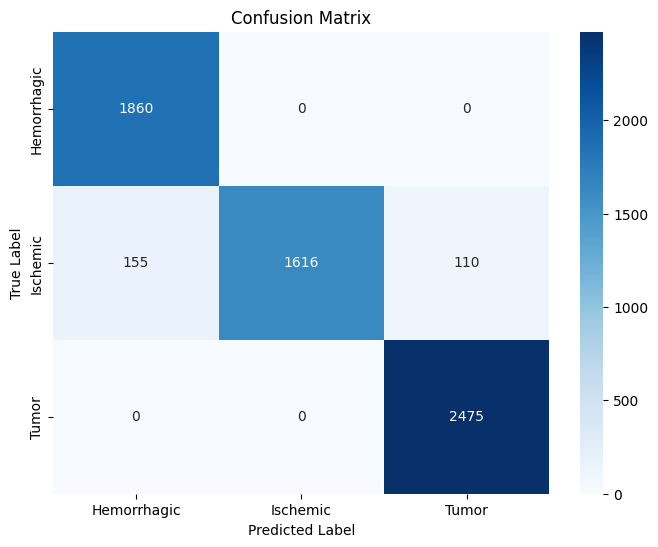

In [29]:
def evaluate_final_model(dataset):
    # Load Best Model
    model = get_model()
    model.load_state_dict(torch.load("best_resnet_model_safe_noisy_data.pth"))
    model.eval()
    
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    all_preds = []
    all_labels = []
    
    print("Generating Evaluation Metrics...")
    with torch.no_grad():
        for images, labels in tqdm(loader):
            images = images.to(DEVICE)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
            
    # Metrics 
    print("\n" + "="*60)
    print(classification_report(all_labels, all_preds, target_names=CLASSES))
    print("="*60)
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=CLASSES, yticklabels=CLASSES)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Run
evaluate_final_model(full_dataset)

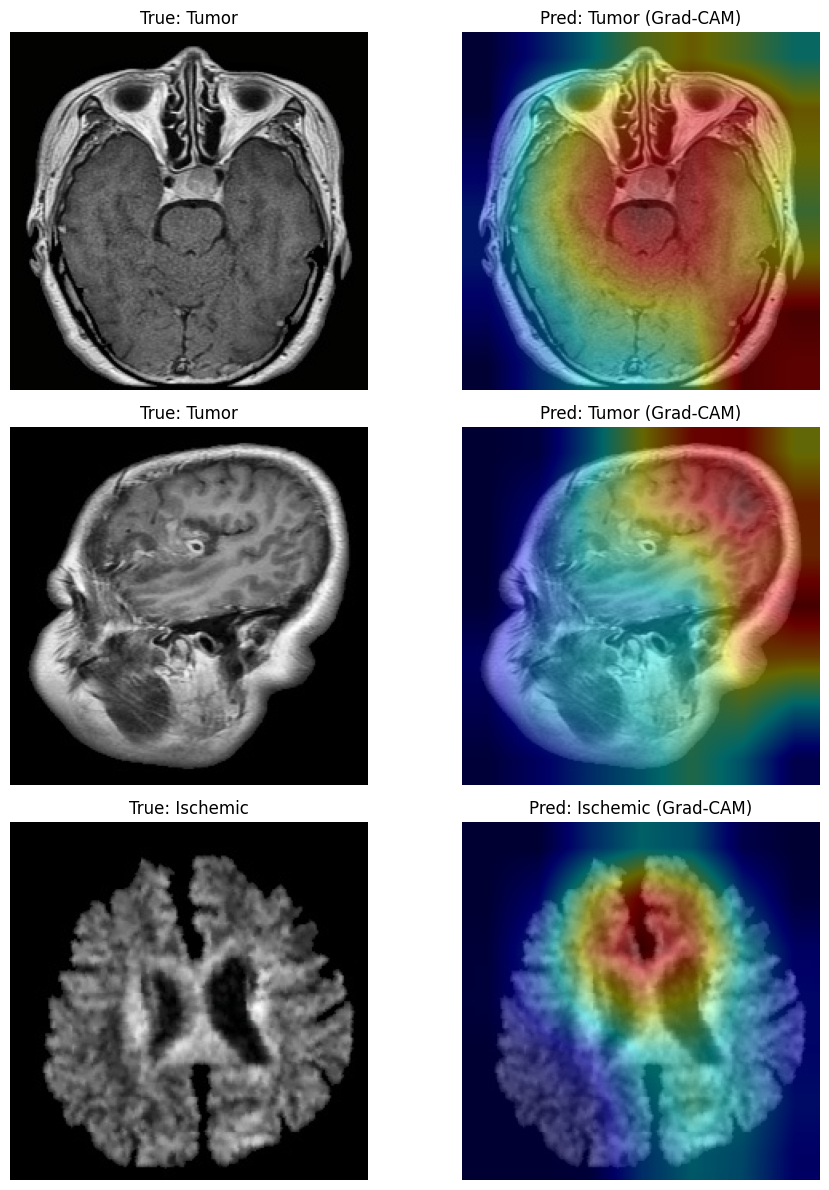

In [45]:
import cv2

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.gradients = None
        self.activations = None
        
        # Hooks
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __call__(self, x, class_idx=None):
        self.model.zero_grad()
        output = self.model(x)
        
        if class_idx is None:
            class_idx = torch.argmax(output)
            
        score = output[0, class_idx]
        score.backward()
        
        # Grad-CAM calculation
        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        activations = self.activations[0]
        
        for i in range(activations.shape[0]):
            activations[i, :, :] *= pooled_gradients[i]
            
        heatmap = torch.mean(activations, dim=0).cpu().detach().numpy()
        heatmap = np.maximum(heatmap, 0)
        
        if np.max(heatmap) != 0:
            heatmap /= np.max(heatmap)
            
        return heatmap, class_idx.item(), CLASSES[class_idx.item()]

def visualize_gradcam_standard(dataset, num_samples=3):
    model = get_model()
    model.load_state_dict(torch.load("best_resnet_model_safe_noisy_data.pth"))
    model.eval()
    
    # Target Layer: ResNet50 Layer 4 (last conv block)
    grad_cam = GradCAM(model, model.layer4[-1])
    
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    plt.figure(figsize=(10, 4 * num_samples))
    
    for i, idx in enumerate(indices):
        image_tensor, label_idx = dataset[idx]
        input_tensor = image_tensor.unsqueeze(0).to(DEVICE)
        
        # Generate Heatmap
        heatmap, pred_idx, pred_name = grad_cam(input_tensor)
        
        # Display Image
        img_disp = image_tensor.permute(1, 2, 0).numpy()
        img_disp = img_disp * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img_disp = np.clip(img_disp, 0, 1)
        
        # Overlay
        heatmap_resized = cv2.resize(heatmap, (224, 224))
        heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
        heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB) / 255.0
        superimposed = 0.6 * img_disp + 0.4 * heatmap_colored
        
        # Plot
        ax1 = plt.subplot(num_samples, 2, i*2 + 1)
        ax1.imshow(img_disp)
        ax1.set_title(f"True: {CLASSES[label_idx]}")
        ax1.axis('off')
        
        ax2 = plt.subplot(num_samples, 2, i*2 + 2)
        ax2.imshow(superimposed)
        ax2.set_title(f"Pred: {pred_name} (Grad-CAM)")
        ax2.axis('off')

    plt.tight_layout()
    plt.show()

# Run
visualize_gradcam_standard(full_dataset)

In [ ]:
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from google.colab import files

def predict_and_explain_single_image(image_path, 
                                     class_model_path="best_resnet_model_safe_noisy_data.pth", 
                                     seg_model_path="unet_lesion_model.pth"):
    
    # 1. Setup Device & Transforms
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Same transform as training
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    # 2. Load Models
    # A. Classification Model (ResNet50)
    class_model = get_model() # Uses the function we defined earlier
    class_model.load_state_dict(torch.load(class_model_path, map_location=device))
    class_model.eval()
    
    # B. Segmentation Model (U-Net)
    seg_model = UNet().to(device) # Uses the class we defined earlier
    seg_model.load_state_dict(torch.load(seg_model_path, map_location=device))
    seg_model.eval()
    
    # 3. Process Image
    img_pil = Image.open(image_path).convert("RGB")
    input_tensor = transform(img_pil).unsqueeze(0).to(device)
    
    # 4. Run Classification
    with torch.no_grad():
        class_output = class_model(input_tensor)
        probs = torch.softmax(class_output, dim=1)
        score, pred_idx = torch.max(probs, 1)
        
    predicted_class = CLASSES[pred_idx.item()]
    confidence = score.item() * 100
    
    # 5. Run Grad-CAM
    # We create a new instance for this specific prediction
    grad_cam = GradCAM(class_model, class_model.layer4[-1])
    heatmap, _, _ = grad_cam(input_tensor, pred_idx)
    
    # 6. Run Segmentation
    with torch.no_grad():
        seg_mask = seg_model(input_tensor)
        seg_mask = seg_mask.cpu().squeeze().numpy()
        seg_mask_bin = (seg_mask > 0.5).astype(np.float32) # Threshold
        
    # 7. Visualization Preparation
    # Convert PIL to CV2 format for overlays
    img_cv = cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)
    img_cv = cv2.resize(img_cv, (224, 224))
    
    # Prepare Grad-CAM Overlay
    heatmap_resized = cv2.resize(heatmap, (224, 224))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    gradcam_overlay = cv2.addWeighted(img_cv, 0.6, heatmap_colored, 0.4, 0)
    gradcam_overlay = cv2.cvtColor(gradcam_overlay, cv2.COLOR_BGR2RGB)
    
    # Prepare original for display
    img_disp = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
    
    # 8. Plot Everything
    plt.figure(figsize=(15, 5))
    plt.suptitle(f"Diagnosis: {predicted_class} | Confidence: {confidence:.2f}%", fontsize=16, fontweight='bold')
    
    # Plot 1: Original Image
    ax1 = plt.subplot(1, 3, 1)
    ax1.imshow(img_disp)
    ax1.set_title("Input Scan")
    ax1.axis('off')
    
    # Plot 2: Grad-CAM (Why?)
    ax2 = plt.subplot(1, 3, 2)
    ax2.imshow(gradcam_overlay)
    ax2.set_title("Grad-CAM Focus (Why?)")
    ax2.axis('off')
    
    # Plot 3: Segmentation (Where?)
    ax3 = plt.subplot(1, 3, 3)
    ax3.imshow(img_disp)
    ax3.imshow(seg_mask_bin, cmap='Reds', alpha=0.5) # Red overlay for lesion
    ax3.set_title("Lesion Segmentation (Where?)")
    ax3.axis('off')
    
    plt.tight_layout()
    plt.show()

# --- INTERACTIVE TEST ---
print("Upload an image to generate the Full Medical Report:")
uploaded = files.upload()

for fn in uploaded.keys():
    predict_and_explain_single_image(fn)